In [6]:
import numpy as np
import os
from pathlib import Path
import igraph as ig
import geopandas as gpd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import BallTree
import math
import logging
import pickle

In [7]:
logger = logging.getLogger("graph_analysis")

In [8]:
EARTH_RADIUS_M = 6_371_009

# Baseline

# Changes in Accessibility

In [9]:
GRAPH_DATA_DIR = Path("/home/rico/Documents/thesis/eda/notebooks/sample_data/transit_graphs")

In [10]:
graph_folders = [d for d in os.listdir(GRAPH_DATA_DIR) if os.path.isdir(GRAPH_DATA_DIR.joinpath(d))]
graphs = [GRAPH_DATA_DIR.joinpath(folder).joinpath(file) for folder in graph_folders for file in os.listdir(GRAPH_DATA_DIR.joinpath(folder)) if Path(file).suffix == '.gml']
graph = graphs[0]

In [11]:
destinations = gpd.read_file("/home/rico/Documents/thesis/eda/data/Amsterdam/non_residential_functions_geojson_latlng.json")
destinations.Functie.unique()

array(['Bedrijven', 'Kantoren', 'Sport', 'Maatschappelijke bijeenkomst',
       'Zorg', 'Onduidelijk', 'Onbemensd', 'Wonen', 'Logies', 'Onderwijs',
       'Detailhandel', 'Ontspanning en vermaak', 'Horeca',
       'Museum en galerie', 'Coffeeshop', 'Prostitutie'], dtype=object)

| Dutch                          | English                     |
|--------------------------------|-----------------------------|
| Bedrijven                      | Companies                   |
| Kantoren                       | Offices                     |
| Sport                          | Sports                      |
| Maatschappelijke bijeenkomst   | Social gathering            |
| Zorg                           | Healthcare                  |
| Onduidelijk                    | Unclear                     |
| Onbemensd                      | Unstaffed                   |
| Wonen                          | Housing                     |
| Logies                         | Lodging                     |
| Onderwijs                      | Education                   |
| Detailhandel                   | Retail                      |
| Ontspanning en vermaak         | Leisure and Entertainment   |
| Horeca                         | Hospitality                 |
| Museum en galerie              | Museum and Gallery          |
| Coffeeshop                     | Coffee shop                 |
| Prostitutie                    | Prostitution                |

In [12]:
cat_to_exclude = ['Wonen', 'Coffeeshop', 'Prostitutie', 'Logies']
destinations = destinations[~destinations.Functie.isin(cat_to_exclude)]

In [13]:
education = destinations[destinations.Functie=='Onderwijs']
education.geometry = gpd.points_from_xy(education.geometry.y, education.geometry.x, crs='EPSG:4326')

/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

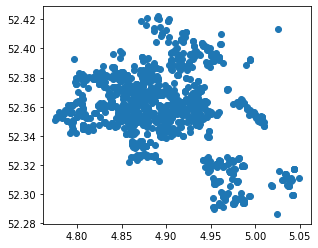

In [14]:
education.plot()

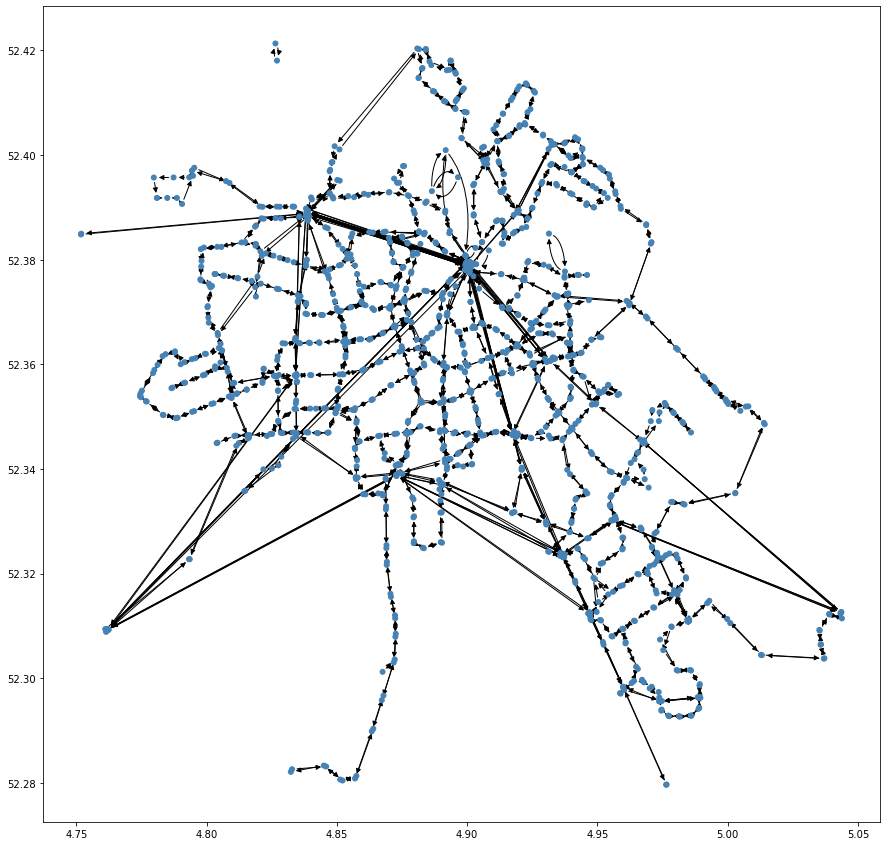

In [15]:
# Read the transit network
G_transit = ig.read(graph)
# g_stop_name_clustering = ig.clustering.VertexClustering.FromAttribute(G_transit, "stop_name")
# membership = g_stop_name_clustering.membership
# # Is in-place
# G_transit.contract_vertices(membership)
fig, ax = plt.subplots(figsize=(15,15))
ig.plot(G_transit, target=ax)

In [16]:
def nearest_nodes_to_points(G, X, Y, return_dist=False):
    """OSMNX nearest_nodes function adapted to igraph
    from https://github.com/gboeing/osmnx/blob/main/osmnx/distance.py: nearest_nodes
    For a given set of geographical locations (X, Y), return the nearest nodes of the given graph G.
    Args:
        G (igraph.Graph): input graph
        X (pandas.Series): X coordinates of the input points
        Y (pandas.Series): Y coordinages of the input points
        return_dist (bool, optional): If True the distance to the nearest node for all points is returned. Defaults to False.
    Returns:
        list: list of nodes of graph G
    """
    if np.isnan(X).any() or np.isnan(Y).any():  # pragma: no cover
        raise ValueError("`X` and `Y` cannot contain nulls")

    # node_ids = np.array([node['node_id'] for node in G.vs])
    nodes = np.array([[node['y'], node['x']] for node in G.vs])

    nodes_rad = np.deg2rad(nodes)
    points_rad = np.deg2rad(np.array([Y, X]).T)

    dist, pos = BallTree(nodes_rad, metric='haversine').query(points_rad, k=1)
    dist = dist[:, 0] * EARTH_RADIUS_M  # convert radians -> meters

    nn = G.vs[pos[:, 0].tolist()]
    nn = list(nn)
    dist = dist.tolist()

    if return_dist:
        return nn, dist
    else:
        return nn

In [17]:
# Read Amstedam Neighborhoods
# Plot them using ams_nb.plot()
ams_nb = gpd.read_file('/home/rico/Documents/thesis/eda/notebooks/sample_data/amsterdam/ams-neighbourhoods.geojson')
ams_nb['centroid'] = gpd.points_from_xy(ams_nb.cent_x, ams_nb.cent_y, crs='EPSG:4326')
ams_nb['res_centroid'] = gpd.points_from_xy(ams_nb.res_cent_x, ams_nb.res_cent_y, crs='EPSG:4326')
education['geometry'] = gpd.points_from_xy(education.geometry.x, education.geometry.y, crs='EPSG:4326')
# Places without residential buildings have no residential centroids. Find them and assign to them the geographical centroid.
ams_nb.loc[ams_nb['res_cent_x'].isna(), 'res_centroid'] = ams_nb[ams_nb['res_cent_x'].isna()]['centroid']

/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [18]:
ams_nb['res_centroid']

0      POINT (4.90009 52.37552)
1      POINT (4.89678 52.37375)
2      POINT (4.89875 52.37283)
3      POINT (4.89423 52.37094)
4      POINT (4.89588 52.36999)
                 ...           
474    POINT (4.98511 52.29471)
475    POINT (4.99445 52.29913)
476    POINT (4.99021 52.29315)
477    POINT (5.01649 52.30562)
478    POINT (5.01314 52.30975)
Name: res_centroid, Length: 479, dtype: geometry

In [24]:
for k, g in enumerate(tqdm(graphs[62:])):
    # Read the transit network
    G_transit = ig.read(g)
    # For each neighborhood, get its nearest node in the network.
    nb_nodes, nb_dist = nearest_nodes_to_points(G_transit, ams_nb['res_centroid'].x, ams_nb['res_centroid'].y, return_dist=True)
    # For each POI, get its nearest node in the network.
    poi_nodes, poi_dist = nearest_nodes_to_points(G_transit, education['geometry'].x, education['geometry'].y, return_dist=True)

    # Calculate travel times between all neighborhoods and all POIs.
    # tt_mx.shape = (nr of neighborhoods (origins), nr of POIs (destinations))
    tt_mx = np.ndarray((len(nb_nodes), len(poi_nodes)))
    td_mx = np.ndarray((len(nb_nodes), len(poi_nodes)))
    modes_mx = np.ndarray((len(nb_nodes), len(poi_nodes)))
    lines_mx = np.ndarray((len(nb_nodes), len(poi_nodes)))
    hops_mx = np.ndarray((len(nb_nodes), len(poi_nodes)))

    failed = {}

    for i, o in enumerate(nb_nodes):
        for j, d in enumerate(poi_nodes):
            # Travel Time
            tt = G_transit.shortest_paths(o, d, weights='travel_time')[0][0]
            if tt == math.inf:
                if not failed.get(f"{o['node_id']}_tt", None) == d['node_id']:
                    # logger.warning(f'Failed to get TRAVEL TIME for {o["node_id"]} - {d["node_id"]}: No path found between them')
                    failed[f"{o['node_id']}_tt"] = d["node_id"]
            else:
                tt_mx[i, j] = tt + poi_dist[j] + nb_dist[i]
            # Travel Distance
            G_transit.es['length'] = np.abs(np.array(G_transit.es['length'])).tolist()
            td = G_transit.shortest_paths(o, d, weights='length')[0][0]
            if td == math.inf:
                if not failed.get(f"{o['node_id']}_td", None) == d["node_id"]:
                    # logger.warning(f'Failed to get TRAVEL DISTANCE for {o["node_id"]} - {d["node_id"]}: No path found between them')
                    failed[f"{o['node_id']}_td"] = d["node_id"]
            else:
                td_mx[i, j] = td + poi_dist[j] + nb_dist[i]
            # Number of hops and number of modes
            edges = G_transit.get_shortest_paths(o, d, weights='length', output='epath')[0]
            if edges == math.inf or not edges:
                if not failed.get(f"{o['node_id']}_edges", None) == d["node_id"]:
                    # logger.warning(f'Failed to get EDGES for {o["node_id"]} - {d["node_id"]}: No path found between them')
                    failed[f"{o['node_id']}_edges"] = d["node_id"]
            else:
                n_modes = len(np.unique(G_transit.es[edges]['route_type']))
                n_lines = len(np.unique(G_transit.es[edges]['unique_route_id']))
                # Add walking if there is some
                modes_mx[i, j] = n_modes + int(poi_dist[j]>0 or nb_dist[i]>0)
                lines_mx[i, j] = n_lines
                # Add walking if there is some
                hops_mx[i, j] = len(edges) + int(poi_dist[j]>0) + int(nb_dist[i]>0)

    with open(f"/home/rico/Documents/thesis/eda/notebooks/tmp/{Path(g).with_suffix('').name}_computation.pkl", "wb") as fp:
        pickle.dump([tt_mx, td_mx, modes_mx, lines_mx, hops_mx, failed], fp)

/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
  0%|          | 0/94 [00:00<?, ?it/s]<ipython-input-24-7c650d540812>:48: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:442
  edges = G_transit.get_shortest_paths(o, d, weights='length', output='epath')[0]
  1%|          | 1/94 [04:10<6:27:35, 250.06s/it]<ipython-input-24-7c650d540812>:48: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:442
  edges = G_transit.get_shortest_paths(o, d, weights='length', output='epath')[0]
  2%|▏         | 2/94 [07:55<6:01:07, 235.51s/it]<ipython-input-24-7c650d540812>:48: RuntimeWarning: Couldn't reach 